In [11]:
import numpy as np
import pyvista as pv
import os
import random
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.spatial import Delaunay
from fast_matching_python.fast_marching import fast_marching
from make_surface_dataset import fmm


def make_uniform_surface_multimesh(f=None, radius=1.0, spacing=0.01, sparse_strides=[10]):
    """
    Generate a fine and coarse uniform triangular mesh over z = f(x,y)
    Returns:
        (fine_graph, fine_faces, fine_points, fine_mesh, fine_h),
        (coarse_graph, coarse_faces, coarse_points, coarse_mesh, coarse_h)
    """
    if f is None:
        f = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
        
        
    # === Helper to build graph and h ===
    def build_graph_and_h(points3d, faces):
        edge_set = set()
        rows, cols, dists, edge_lengths = [], [], [], []
        for face in faces:
            for i in range(3):
                a, b = face[i], face[(i+1)%3]
                edge = tuple(sorted((a,b)))
                if edge not in edge_set:
                    edge_set.add(edge)
                    dist = np.linalg.norm(points3d[a] - points3d[b])
                    edge_lengths.append(dist)
                    rows += [a, b]
                    cols += [b, a]
                    dists += [dist, dist]
        graph = csr_matrix((dists, (rows, cols)), shape=(len(points3d), len(points3d)))
        h = np.mean(edge_lengths)
        return graph, h


    # === Fine hex grid ===
    x_range = np.arange(-radius, radius + spacing, spacing)
    y_range = np.arange(-radius, radius + spacing * np.sqrt(3)/2, spacing * np.sqrt(3)/2)
    xx, yy = np.meshgrid(x_range, y_range)
    xx[::2, :] += spacing / 2  # Hexagonal shift

    x_fine = xx.ravel()
    y_fine = yy.ravel()
    z_fine = f(x_fine, y_fine)
    points2d_fine = np.column_stack((x_fine, y_fine))
    points3d_fine = np.column_stack((x_fine, y_fine, z_fine)).astype(np.float32)

    tri_fine = Delaunay(points2d_fine)
    faces_fine = tri_fine.simplices

    mesh_fine = pv.PolyData()
    mesh_fine.points = points3d_fine
    mesh_fine.faces = np.hstack([[3, *face] for face in faces_fine])

    graph_fine, h_fine = build_graph_and_h(points3d_fine, faces_fine)

    # === Coarse mesh: subsample using stride in 2D grid ===
    sub_meshes = []
    for sparse_stride in sparse_strides:
        mask = np.zeros(xx.shape, dtype=bool)
        mask[::sparse_stride, ::sparse_stride] = True
        x_coarse = xx[mask]
        y_coarse = yy[mask]
        z_coarse = f(x_coarse, y_coarse)
        points2d_coarse = np.column_stack((x_coarse, y_coarse))
        points3d_coarse = np.column_stack((x_coarse, y_coarse, z_coarse)).astype(np.float32)

        tri_coarse = Delaunay(points2d_coarse)
        faces_coarse = tri_coarse.simplices

        mesh_coarse = pv.PolyData()
        mesh_coarse.points = points3d_coarse
        mesh_coarse.faces = np.hstack([[3, *face] for face in faces_coarse])

        
        graph_coarse, h_coarse = build_graph_and_h(points3d_coarse, faces_coarse)
        
        sub_meshes.append((graph_coarse, faces_coarse, points3d_coarse, mesh_coarse, h_coarse))


    coordinates_to_fine_point_index = {tuple(coor): idx for idx, coor in enumerate(points3d_fine)}
    return ((graph_fine, faces_fine, points3d_fine, mesh_fine, h_fine), sub_meshes, coordinates_to_fine_point_index)


In [12]:
import numpy as np

# 1. Radial sine ripple
def ripple(x, y, A=1.0, k=2):
    r = np.sqrt(x**2 + y**2)
    return A * np.sin(k * r)

# 2. Gaussian “bump” or hill
def gaussian_hill(x, y, A=3.0, sigma=1.5):
    return A * np.exp(-((x**2 + y**2) / (2 * sigma**2)))

# 3. Mexican hat (Ricker) wavelet
def mexican_hat(x, y, A=3.0, sigma=1.5):
    r2 = x**2 + y**2
    s2 = sigma**2
    return A * (1 - r2/s2) * np.exp(-r2/(2*s2))

# 4. Saddle surface (hyperbolic paraboloid)
def saddle(x, y, a=2.0, b=2.0):
    return (x**2 / a**2) - (y**2 / b**2)

# 5. Elliptic paraboloid (bowl)
def paraboloid(x, y, a=2.0, b=2.0):
    return (x**2 / a**2) + (y**2 / b**2)

# 6. Sinusoidal grid waves
def grid_waves(x, y, A=0.5, kx=3.0, ky=3.0):
    return A * (np.sin(kx * x) + np.sin(ky * y))

# 7. Checkerboard of Gaussian bumps
def bump_grid(x, y, A=1.0, sigma=0.5, spacing=3):
    # place little Gaussians at grid centers
    xi = np.round(x/spacing) * spacing
    yi = np.round(y/spacing) * spacing
    return A * np.exp(-(((x-xi)**2 + (y-yi)**2) / (2*sigma**2)))

# 11. User‐combination: mix two surfaces
def mix_surfaces(f1, f2, alpha=0.5):
    return lambda x, y: alpha*f1(x, y) + (1-alpha)*f2(x, y)


In [13]:
import torch
import heapq
import pyvista as pv
import numpy as np
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
from models.sphere_models import SpherePointNetRing, SpherePointNetRingFeatureExtractionFirstRing, SpherePointNetRingAttention, SpherePointNetRingAttentionAndConvolution

global_local_solver = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def make_sphere(radius=1.0, nsub=3):
    # sphere = pv.Sphere(radius=radius, theta_resolution=theta_resolution//2, phi_resolution=phi_resolution)
    sphere = pv.Icosphere(radius=radius, nsub=nsub)  # More uniform

    points = sphere.points.astype(np.float32)
    faces = sphere.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)  
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)

    return graph, faces, points, sphere, h

def plot_errors(h_values, errors_regular_FMM, errors_saar_model):
    plt.figure()
    plt.loglog(h_values, errors_regular_FMM, marker='o', label='Regular FMM')
    plt.loglog(h_values, errors_saar_model, marker='s', label='Saar Model')
    plt.xlabel('Mean edge length h')
    plt.ylabel('L1 Loss')
    plt.title('Convergence Plot (Log-Log)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


def get_3_ring_visited_neighbors(p, graph, status, u, points):
    visited = []
    queue = deque([(p, 0)])  # (node, depth)
    seen = set([p])
    
    while queue:
        current, depth = queue.popleft()
        if depth > 3:
            continue
        if status[current] == 'Visited' and current != p:
            point_xyz = tuple(points[current])  # (x, y, z)
            visited.append([point_xyz[0], point_xyz[1], point_xyz[2], u[current]])
        for neighbor in graph[current].nonzero()[1]:
            if neighbor not in seen:
                seen.add(neighbor)
                queue.append((neighbor, depth + 1))

    return torch.tensor(visited, dtype=torch.float32).T  # Shape: [4, N]


def local_solver_dijkstra(p, graph, status, u, points):
    min_val = np.inf
    for neighbor in graph[p].nonzero()[1]:
        if status[neighbor] == 'Visited':
            candidate = u[neighbor] + graph[p, neighbor]
            if candidate < min_val:
                min_val = candidate
    return min_val


def local_solver_ron(p, graph, status, u, points):
    neighbors = graph[p].nonzero()[1]
    visited_neighbors = [n for n in neighbors if status[n] == 'Visited']

    if not visited_neighbors:
        return u[p] 

    min_u = min(u[n] + np.linalg.norm(points[p] - points[n]) for n in visited_neighbors)

    best_u = min_u
    for i in range(len(visited_neighbors)):
        for j in range(i + 1, len(visited_neighbors)):
            a, b = visited_neighbors[i], visited_neighbors[j]
            ua, ub = u[a], u[b]
            pa, pb, pp = points[a], points[b], points[p]
            dab = np.linalg.norm(pa - pb)

            # Upwind Eikonal solver
            if abs(ua - ub) >= dab:
                continue  # upwind condition not met, use min

            s = (ua + ub + np.sqrt(2 * dab**2 - (ua - ub)**2)) / 2
            if s < best_u:
                best_u = s

    return best_u


def local_solver_model_ring3(p, graph, status, u, points): #fast
    visited_neighbors = get_3_ring_visited_neighbors(p, graph, status, u, points).to(device)  # shape: (4, N) with N ≤ 90
    num_valid = visited_neighbors.shape[1]
    visited_neighbors_padded = F.pad(visited_neighbors, (0, 90 - num_valid), "constant", 0).unsqueeze(0)  # (1, 4, 90)
    mask = torch.zeros(90, dtype=torch.float32)
    mask[:num_valid] = 1
    mask = mask.unsqueeze(0)  # (1, 90)
    point_xyz = torch.tensor(points[p], dtype=torch.float32).unsqueeze(0)  # (1, 3)
    visited_neighbors_padded = visited_neighbors_padded.to(device)
    point_xyz = point_xyz.to(device)
    mask = mask.to(device)
    
    distance_estimation = global_local_solver(visited_neighbors_padded, point_xyz, mask).item()
    return distance_estimation


# def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver): NOT REAL!
#     n_points = graph.shape[0]
#     u = np.full(n_points, np.inf)
#     status = np.full(n_points, 'Unvisited', dtype=object)
#     heap = []  # (u value, point index)

#     for p in source_points:
#         u[p] = 0
#         status[p] = 'Visited'
#         for neighbor in graph[p].nonzero()[1]:
#             if status[neighbor] == 'Unvisited':
#                 status[neighbor] = 'Wavefront'
#                 heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))

#     while heap:
#         _, p = heapq.heappop(heap)
#         if status[p] == 'Visited':
#             continue 

#         u[p] = local_solver(p, graph, status, u, points)
#         status[p] = 'Visited'

#         for neighbor in graph[p].nonzero()[1]:
#             if status[neighbor] == 'Unvisited' or status[neighbor] == 'Wavefront': #Omer added
#                 if status[neighbor] == 'Unvisited':
#                     status[neighbor] = 'Wavefront'
#                     u[neighbor] = u[p] + graph[p, neighbor]
#                 else:
#                     new_distance = u[p] + graph[p, neighbor]
#                     if new_distance < u[neighbor]:
#                         u[neighbor] = new_distance
#                 heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
#     return u


def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver):  #Implementation of the "real" FMM
    n_points = graph.shape[0]
    u = np.full(n_points, np.inf)
    status = np.full(n_points, 'Unvisited', dtype=object)
    heap = []  # (u value, point index)

    for p in source_points:
        u[p] = 0
        status[p] = 'Visited'
        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited':
                status[neighbor] = 'Wavefront'
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))

    while heap:
        _, p = heapq.heappop(heap)
        if status[p] == 'Visited':
            continue

        u[p] = local_solver(p, graph, status, u, points)
        status[p] = 'Visited'

        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited':
                status[neighbor] = 'Wavefront'
                u[neighbor] = local_solver(neighbor, graph, status, u, points)
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
            elif status[neighbor] == 'Wavefront':
                new_distance = local_solver(neighbor, graph, status, u, points)
                if new_distance < u[neighbor]:
                    u[neighbor] = new_distance
                    heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
    return u

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


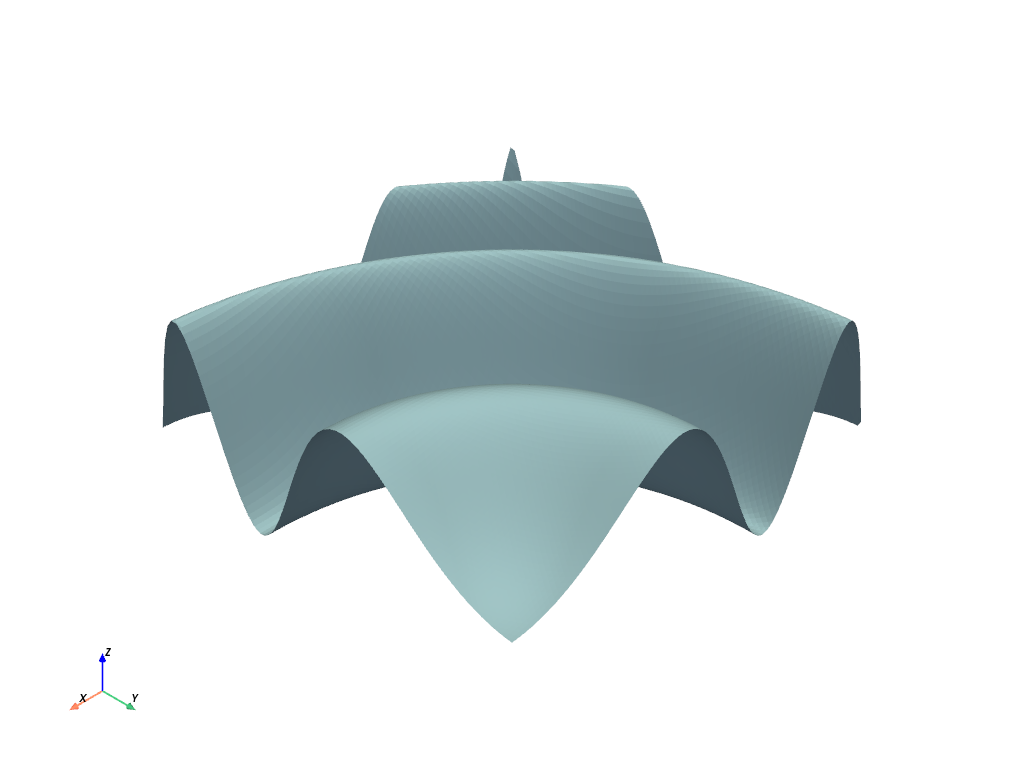

15.195371627807617


/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


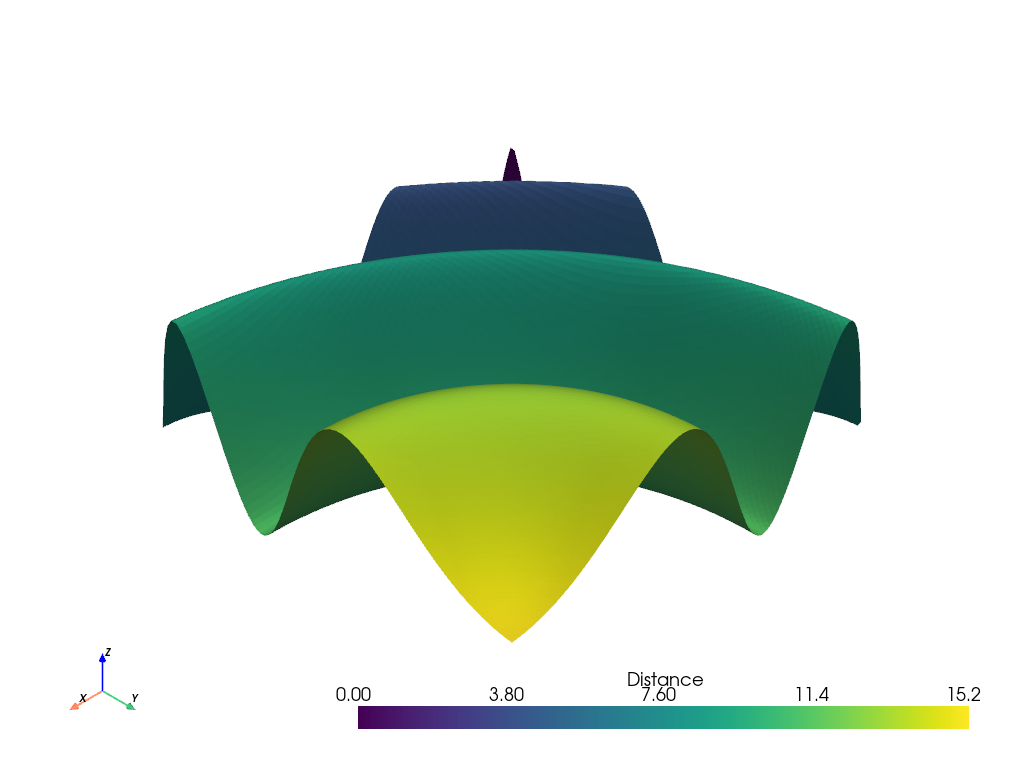

In [14]:
# from our_test import FMM_with_local_solver, local_solver_model_ring3, global_local_solver
# from models.sphere_models import SpherePointNetRingAttentionAndConvolution
# import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



surface_func = lambda x, y: np.sin(0.4*((x-2.5)**2+(y-2.5)**2))
    
(graph_high_res, faces_high_res, points3d_high_res, mesh_high_res, h_high_res), sub_meshes, coor_to_index = \
    make_uniform_surface_multimesh(f=surface_func, radius=2.5, spacing=0.05, sparse_strides=[10])

mesh_high_res.plot()

local_solver = SpherePointNetRingAttentionAndConvolution()
checkpoint = torch.load("checkpoints/dropout=0.1 num_heads=16/surface_attention_epoch10_loss1.5072902242069192e-06.pt", map_location=device)
local_solver.load_state_dict(checkpoint["model_state_dict"])
local_solver = local_solver.to(device)
local_solver.eval()
global_local_solver = local_solver

distances = FMM_with_local_solver(graph_high_res, points3d_high_res, [0], local_solver_model_ring3)

print(np.max(distances))

mesh_high_res["Distance"] = distances
mesh_high_res.plot(scalars="Distance", cmap="viridis", show_edges=False)

In [15]:
distances_fmm = fmm(V=points3d_high_res, F=faces_high_res, source_index=0)
np.max(distances_fmm)

[                                                  ]                                                   ] 0%

15.641090899287997